## Q3 ~ Amy

In [16]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import json
import pandas as pd

import plotly.graph_objects as go
from datetime import datetime, timedelta
import time
import numpy as np

import scipy
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import matplotlib as plt

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# store login data in login.py
%run login.py

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""
import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
token = mylogin.json()['data']['logIn']['jwt']['token']
expdate = mylogin.json()['data']['logIn']['jwt']['exp']

In [2]:
query2 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""

peds = requests.post(url, json={'query': query2}, headers = {'Authorization':token})


p = peds.json()['data']['feedCountMetrics']['edges']
query1 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["bicycle"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
bikes = requests.post(url, json={'query': query1}, headers = {'Authorization':token})

b = bikes.json()['data']['feedCountMetrics']['edges']

query3 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["car"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
cars = requests.post(url, json={'query': query3}, headers = {'Authorization':token})

c = cars.json()['data']['feedCountMetrics']['edges']

In [3]:
# count 500 hrs when there is a pedestrian passing by
query2 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York",
    interval:"1h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""

pe = requests.post(url, json={'query': query2}, headers = {'Authorization':token})


ph = pe.json()['data']['feedCountMetrics']['edges']
query1 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["bicycle"],
    timezone:"America/New_York",
    interval:"1h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
bikesh = requests.post(url, json={'query': query1}, headers = {'Authorization':token})

bh = bikesh.json()['data']['feedCountMetrics']['edges']

query3 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["car"],
    timezone:"America/New_York",
    interval:"1h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
carsh = requests.post(url, json={'query': query3}, headers = {'Authorization':token})

ch = carsh.json()['data']['feedCountMetrics']['edges']

In [4]:
query0 = """
query {
  devices {
    count
    edges {
      node {
        rawId
        name
        serialno
      }
    }
  }
}
"""
s = requests.post(url, json={'query': query0}, headers = {'Authorization':token})



In [5]:
from datetime import datetime


def create_df(sensor):
    if sensor == 'Streetscape':
        s = 'SWLSANDBOX1'
    if sensor == 'Outside':
        s = 'SWLSANDBOX3'
    if sensor == 'UnderRaincoat':
        s = s = 'SWLSANDBOX2'
    df = pd.DataFrame(columns = ['Date', 'Number of Pedestrians', "Day of Week", 'Bikes', 'Cars', 'Total'])
    for node in p:
        if node['node']['serialno'] == s:
            date = datetime.strptime(node['node']['time'][:10], '%Y-%m-%d')
            df = df.append({'Date': date, 'Number of Pedestrians': node['node']['result'], "Day of Week" : date.strftime('%A')}, ignore_index=True)
    df.set_index('Date', inplace=True)

    for node in b:
        if node['node']['serialno'] == s:
            date = datetime.strptime(node['node']['time'][:10], '%Y-%m-%d')
            df['Bikes'][date] = node['node']['result']

    for node in c:
        if node['node']['serialno'] == s:
            date = datetime.strptime(node['node']['time'][:10], '%Y-%m-%d')
            df['Cars'][date] = node['node']['result']


    df['Total'] = df['Number of Pedestrians'] + df['Cars'] + df['Bikes']
    df[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']] = df[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']].astype('int32')
    
    
    return df


# Outside = pd.DataFrame(columns = ['Date', 'Number of Pedestrians', "Day of Week", 'Bikes', 'Cars', 'Total'])
# UnderRaincoat = pd.DataFrame(columns = ['Date', 'Number of Pedestrians', "Day of Week", 'Bikes', 'Cars', 'Total'])
street_df = create_df('Streetscape')
outside_df = create_df('Outside')
raincoat_df = create_df('UnderRaincoat')


In [6]:

def plot_up_to(column, start_date, end_date, device):
    
    if device == 'Streetscape':
        df = street_df
    if device == 'Outside':
        df = outside_df
    if device == 'UnderRaincoat':
        df = raincoat_df
    
  
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    plot_df[column].iplot(mode='lines',
                                   xTitle='Date',
                                   yTitle=column, 
                                  title=f'{column.title()}  between {start_date.date()} and {end_date.date()}.')
    
_ = interact(plot_up_to, column=widgets.Dropdown(options=['Number of Pedestrians', 'Total', 'Bikes', 'Cars'], value = 'Number of Pedestrians'), 
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
            device = widgets.Dropdown(options=list(devices.keys())))

interactive(children=(Dropdown(description='column', options=('Number of Pedestrians', 'Total', 'Bikes', 'Cars…

In [7]:
def remove_outliers(df):
    testing_df = df.drop(df[df.Total == 0].index)
    q1 = testing_df['Total'].quantile(0.10)
    q3 = testing_df['Total'].quantile(0.90)

    interquartile_range = q3 - q1

    df = df[~((df['Total'] < (q1)) \
             |(df['Total'] > (q3)))]
    return df

cleaned_s = remove_outliers(street_df)
cleaned_o = remove_outliers(outside_df)
cleaned_r = remove_outliers(raincoat_df)

In [24]:
import seaborn as sns
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def plot_week_days(column, start_date, end_date, device):
    if device == 'Streetscape':
        df = cleaned_s
    if device == 'Outside':
        df = cleaned_o
    if device == 'UnderRaincoat':
        df = cleaned_r
        
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    ax = sns.barplot(x="Day of Week", y=column, data= plot_df.groupby(['Day of Week'])[column].mean().reset_index(), order = order, palette = 'muted')
    ax.set_title(f'Mean Counts for {column.title()} by Weekday Without Outliers')
    
_ = interact(plot_week_days, column=widgets.Dropdown(options=['Number of Pedestrians', 'Total', 'Bikes', 'Cars']), 
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
            device = widgets.Dropdown(options=list(devices.keys())))



interactive(children=(Dropdown(description='column', options=('Number of Pedestrians', 'Total', 'Bikes', 'Cars…

In [9]:
from datetime import datetime


def create_hourly_df(sensor):
    hourly = pd.DataFrame(columns = ['Date', 'Number of Pedestrians', "Day of Week", 'Bikes', 'Cars'])
    for node in ph:
        if node['node']['serialno'] == sensor:
            date = node['node']['time'][:10]
            hr = node['node']['time'][11:16]
            time = date +' '+ hr
            date = datetime.strptime(time, '%Y-%m-%d %H:%M')
            hourly = hourly.append({'Date': date, 'Number of Pedestrians': node['node']['result'], "Day of Week" : date.strftime('%A')}, ignore_index=True)
    hourly.set_index('Date', inplace=True)

    for node in bh:
        if node['node']['serialno'] == sensor:
            date = node['node']['time'][:10]
            hr = node['node']['time'][11:16]
            time = date +' '+ hr
            date = datetime.strptime(time, '%Y-%m-%d %H:%M')
            hourly['Bikes'][date] = node['node']['result']

    for node in ch:
        if node['node']['serialno'] == sensor:
            date = node['node']['time'][:10]
            hr = node['node']['time'][11:16]
            time = date +' '+ hr
            date = datetime.strptime(time, '%Y-%m-%d %H:%M')
            hourly['Cars'][date] = node['node']['result']


    hourly['Total'] = hourly['Number of Pedestrians'] + hourly['Cars'] + hourly['Bikes']
    hourly[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']] = hourly[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']].astype('int32')
    hourly['Hour'] = hourly.index.time
    return hourly

street_hourly = create_hourly_df('SWLSANDBOX1')
outside_hourly = create_hourly_df('SWLSANDBOX3')
raincoat_hourly = create_hourly_df('SWLSANDBOX2')

In [10]:
import plotly.graph_objects as go
from datetime import datetime, timedelta

def plot_maintenance(column, start_date, end_date, device, dates):
    if device == 'Streetscape':
        df = street_df
    if device == 'Outside':
        df = outside_df
    if device == 'UnderRaincoat':
        df = raincoat_df
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
#     fig = go.Figure()

#     # Add scatter trace for line
#     fig.add_trace(go.Scatter(
#         x=plot_df.index,
#         y=plot_df.Total,
#         mode="lines",
#         name="Total Objects"
#     ))
#     shapes = list()
#     for date in dates:
#             shapes.append(
#                 dict(
#                 type="rect",
#                 # x-reference is assigned to the x-values
#                 xref="x",
#                 # y-reference is assigned to the plot paper [0,1]
#                 yref="paper",
#                 x0=date,
#                 y0=0,
#                 x1= date + timedelta(hours=9),
#                 y1=1,
#                 fillcolor="Red",
#                 opacity=0.5,
#                 layer="above",
#                 line_width=0,
#             ))   
#     # Add shape regions
    
    fig.update_layout(
        shapes = shapes,
        title=f'Maintenance schedule for {column.title()}  between {start_date.date()} and {end_date.date()}.',
        xaxis_title="Date",
        yaxis_title=column,
    )
    iplot(fig)
    
# _ = interact(plot_maintenance, column= 'Total', 
#              start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
#              end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
#             device = widgets.Dropdown(options=list(devices.keys())))

In [27]:
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + timedelta(days_ahead)

def get_maintenance(hours, device, day, start_date, end_date):
    saved_dates = []
    if device == 'Streetscape':
        df = street_hourly
    if device == 'Outside':
        df = outside_hourly
    if device == 'UnderRaincoat':
        df = raincoat_hourly
        
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    
    dates = []
    count = 0
    for index, row in plot_df.iterrows():
        if row['Total'] > 0 & row['Total'] < hours:
            count += 1
        if row['Total'] >= hours/2:
            count += row['Total']
        if count >= hours:
            if day == "Any":
                d = index + timedelta(days=1)
            else:
                d = next_weekday(index, time.strptime(day, "%A").tm_wday)
            d = d.replace(hour=16, minute=0, second=0)
            saved_dates.append(d)
            count = 0
    dates = pd.Series(saved_dates) 
    dates = dates.rename("Maintenance Dates")
    dates.drop_duplicates(keep='first', inplace=True)
    dates.to_list()
    plot_maintenance('Total', start_date, end_date, device, dates)
    dates = dates.to_frame()
    
    dates=dates.reset_index(drop = True)
    dates.to_csv('maintenance.txt', sep=' ', index=False)


# st_maintenance = get_maintenance(street_hourly, 500)
a = interact_manual(get_maintenance, hours = (0,2000,10),
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
            device = widgets.Dropdown(options=list(devices.keys())),
            day = widgets.Dropdown(options=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "Any"], value = "Saturday"))


interactive(children=(IntSlider(value=1000, description='hours', max=2000, step=10), Dropdown(description='dev…

In [12]:
import seaborn as sns

def plot_day_times(column, start_date, end_date, device):
    if device == 'Streetscape':
        df = street_hourly
    if device == 'Outside':
        df = outside_hourly
    if device == 'UnderRaincoat':
        df = raincoat_hourly
        
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    
    plot_df["Hour"] = plot_df["Hour"].astype(str)
    plot_df["Hour"] = plot_df["Hour"].str.slice(0, 2, 1) 
    hour_df = pd.DataFrame()
    hour_df[column] = plot_df.groupby('Hour')[column].mean()
    ax = sns.barplot(x = hour_df.index, y=column, data= hour_df, color="skyblue")
    
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    ax.set_title(f'Mean Counts for {column.title()} by Hour')
   
_ = interact(plot_day_times, column=widgets.Dropdown(options=['Number of Pedestrians', 'Total', 'Bikes', 'Cars']), 
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
            device = widgets.Dropdown(options=list(devices.keys())))


interactive(children=(Dropdown(description='column', options=('Number of Pedestrians', 'Total', 'Bikes', 'Cars…

In [13]:
import numpy as np
df = street_df
df['Quarter'] = df.index.month
df['Quarter'] = np.ceil(df['Quarter']/3).astype(int)
cleaned_s['Quarter']= df['Quarter']

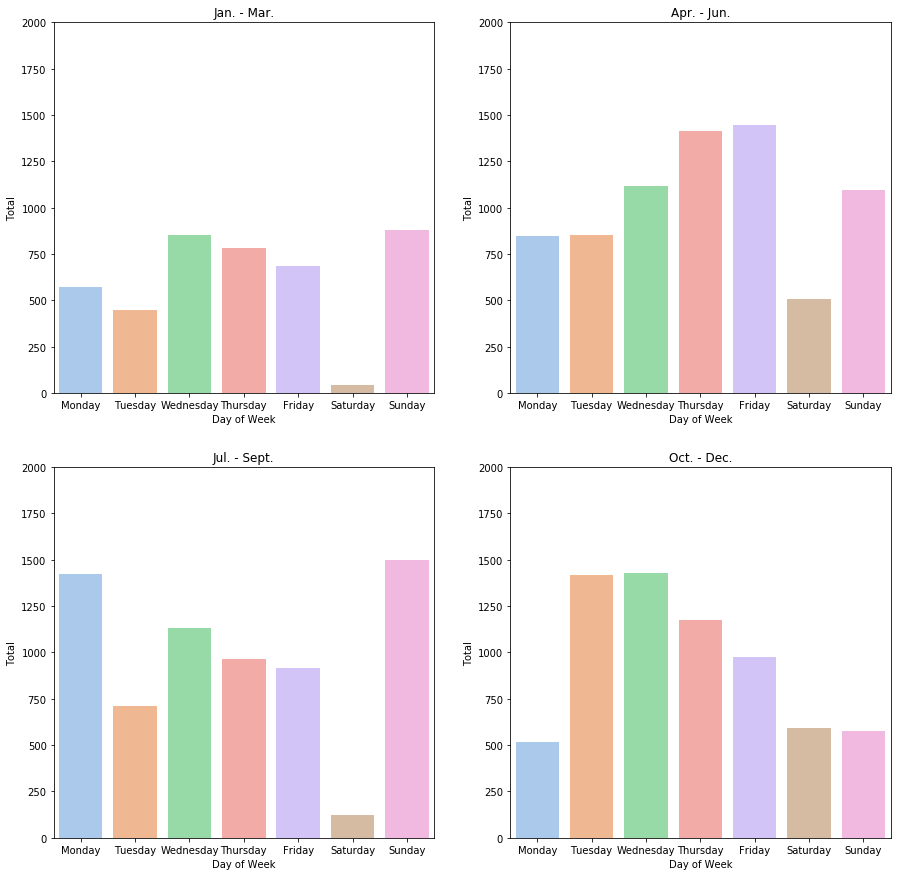

In [14]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten the 2D axes array for ease of looping
axes = np.array(axes).flatten()

# Prepare the month description titles for each quarter
quarter_names = ['Jan. - Mar.', 'Apr. - Jun.', 'Jul. - Sept.', 'Oct. - Dec.']
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for q, ax in zip(sorted(cleaned_s['Quarter'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
    
    # Set the y-axis range for consistency across the four graphs
    ax.set_ylim(0, 2000)
    ax.set_ylabel('Average Daily Trips')
    
    sns.barplot(
        x='Day of Week', 
        y='Total', 
        data=cleaned_s[cleaned_s['Quarter']==q].groupby('Day of Week')['Total'].mean().reset_index(),
        ax=ax,
        order = order,
        palette="pastel"
    )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/calmap/__init__.py:221: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



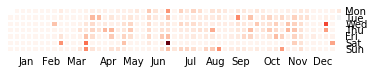

In [15]:
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap

fig = calmap.yearplot(df['Total'], year=2019)


In [29]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
cleaned_s[cleaned_s['Quarter']==q].groupby('Day of Week')['Total'].mean().reindex(order)


Day of Week
Monday        517.500000
Tuesday      1416.545455
Wednesday    1428.500000
Thursday     1177.888889
Friday        977.750000
Saturday      592.250000
Sunday        578.000000
Name: Total, dtype: float64